In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

2024-04-14 23:19:56.920882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 23:19:57.182684: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 23:19:58.192261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-14 23:19:58.192304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missi

In [3]:
import torch


In [4]:
torch.cuda.empty_cache()


In [5]:
import pandas as pd
test = pd.read_csv("test.csv")
test = test.dropna()
df = pd.read_csv("train.csv")
df = df.dropna()
print(df.head())
print(test.head())

   Unnamed: 0                                             review  label
0        3774  Having avoided seeing the movie in the cinema,...      0
1       48396  With this movie I was really hoping that the i...      0
2        1980  Raymond Burr stars as an attorney caught up in...      0
3        6703  A lot people get hung up on this films tag as ...      1
4       28168  I was a fan of Buffy and hoped it would come t...      0
   Unnamed: 0                                             review  label
0       33553  I really liked this Summerslam due to the look...      1
1        9427  Not many television shows appeal to quite as m...      1
2         199  The film quickly gets to a major chase scene w...      0
3       12447  Jane Austen would definitely approve of this o...      1
4       39489  Expectations were somewhat high for me when I ...      0


In [6]:
df.label

0        0
1        0
2        0
3        1
4        0
        ..
39995    0
39996    1
39997    0
39998    1
39999    0
Name: label, Length: 40000, dtype: int64

In [7]:
print(df['label'].value_counts())


label
0    20039
1    19961
Name: count, dtype: int64


label
0    20039
1    19961
Name: count, dtype: int64


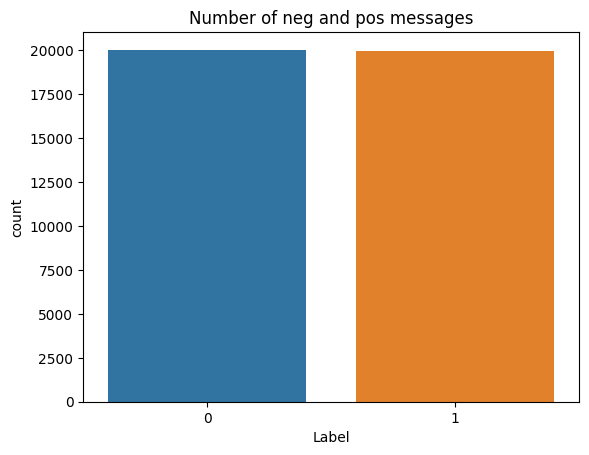

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the value counts of the label column
print(df['label'].value_counts())

# Plot the countplot
sns.countplot(x='label', data=df)
plt.xlabel('Label')
plt.title('Number of neg and pos messages')
plt.show()


In [9]:
data = df.review.tolist()
label = df.label.tolist()
data_test = test.review.tolist()
label_test = test.label.tolist()
data_n = []
for i in data:
  i = i.replace('_','')
  data_n.append(i)
test_v = []
for i in data_test:
  i = i.replace('_','')
  test_v.append(i)

In [10]:
import numpy as np

def load_fasttext_vec(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the first line, which contains metadata about the file
        first_line = file.readline()
        
        # Read each line of the file
        for line in file:
            values = line.strip().split()
            # The first value is the word
            word = values[0]
            # The remaining values are the vector
            vector = np.asarray(values[1:], dtype='float32')
            # Add word and vector to the dictionary
            embeddings_index[word] = vector
    return embeddings_index

# Specify the path to your FastText .vec file
fasttext_vec_file_path = 'cc.vi.300.vec'

# Load the embeddings from the .vec file
embeddings_index = load_fasttext_vec(fasttext_vec_file_path)

# Print an example vector for a specific word
example_word = 'từ'  # Change to any word you want to check
print(f'Vector for "{example_word}": {embeddings_index[example_word]}')


Vector for "từ": [ 4.2500e-02 -4.6700e-02 -1.4540e-01 -1.6430e-01 -3.1600e-02 -1.3670e-01
  2.8500e-02 -8.5700e-02  7.2200e-02  7.1000e-02  5.5200e-02 -6.2300e-02
 -2.6760e-01  1.0650e-01 -6.1400e-02 -1.3080e-01 -1.4800e-02  7.1900e-02
  1.3700e-02 -1.2000e-01  6.3800e-02 -9.5000e-03  1.3990e-01 -8.3000e-02
  2.8900e-02 -1.0660e-01  2.7020e-01  7.2600e-02  1.7790e-01 -9.5300e-02
 -1.5510e-01 -1.6900e-02 -9.1400e-02  1.1340e-01 -3.7200e-02 -9.1000e-03
 -7.7500e-02 -1.4700e-02  1.2000e-02  1.2900e-01  1.1730e-01  1.2790e-01
  1.6810e-01 -3.3000e-03 -2.1200e-02  5.3300e-02 -3.9400e-02 -3.6400e-02
  1.2520e-01  2.4300e-02  3.2100e-02  1.8040e-01  2.4940e-01 -1.7950e-01
  1.3090e-01  1.5120e-01  7.8000e-03  1.0310e-01 -6.6700e-02 -6.0800e-02
 -1.3900e-02  1.7340e-01 -1.8000e-03  2.9570e-01  1.2890e-01  1.2950e-01
 -1.0000e-01 -3.4600e-02 -5.7000e-03 -5.7000e-02 -5.1400e-02 -8.1000e-03
  3.4000e-02 -2.7690e-01 -1.1310e-01  4.7190e-01  1.4150e-01  5.9000e-03
 -1.7500e-02 -5.5700e-02  2.8100e-

In [11]:
import pickle

# Specify the path where you want to save the pickle file
pickle_file_path = 'embeddings_index_vi.pickle'  # Change this to your desired path

# Save the embeddings dictionary to a pickle file
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(embeddings_index, pickle_file)


In [12]:
import pickle
with open('embeddings_index_vi.pickle' , 'rb') as pickle_file:
    embeddings_index = pickle.load(pickle_file)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data_n)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

sequences =  tokenizer.texts_to_sequences(data_n)
# maxlen = max([len(i) for i in data_n])
maxlen = 300
data = pad_sequences(sequences, maxlen=maxlen)

le = LabelEncoder()

label = le.fit_transform(label)
labels = label.reshape(-1,1)
labels_test = le.fit_transform(label_test)
labels_test = labels_test.reshape(-1,1)
# labels = to_categorical(np.asarray(label))
# labels_test = to_categorical(np.asarray(label_test))
print('Shape of data tensor:', data.shape)
x_train,x_val,y_train,y_val = train_test_split(data,labels,test_size=0.15, random_state=48)

In [ ]:
def convert_to_sequences(texts):
  sequences =  tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=maxlen)

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
print(300)
print(embedding_matrix.shape)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(len(word_index)+1,300,input_length=maxlen)(inputs)
    layer = LSTM(units=256)(layer)
    layer = Dense(256,activation = 'relu')(layer)
    layer = Dense(1,activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
from keras.callbacks import ModelCheckpoint

model = RNN()
checkpoint = ModelCheckpoint('weights_lstm_NCT_SV_fastext_sentece.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(x_train,y_train,batch_size=128,epochs=10,verbose=1,
          callbacks=[checkpoint], validation_data=[x_val,y_val])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
#model = load_model('C:/Users/hari shivani gudi/Downloads/Test/weights_lstm_NCT_SV_fastext_sentece.hdf5')

In [ ]:
from sklearn import metrics
acc = model.predict(convert_to_sequences(test_v))
accr = np.round(acc)
print(metrics.f1_score(labels_test, accr))
print(metrics.precision_score(labels_test, accr))
print(metrics.recall_score(labels_test, accr))

In [ ]:
accuracy = metrics.accuracy_score(labels_test, accr)

print("Accuracy:", accuracy)